In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import (
    CartesianRepresentation, CylindricalRepresentation,
    UnitSphericalRepresentation)
from astropy.visualization import quantity_support
from scipy.signal.windows import tukey

import time as timer

import sys
sys.path.append('..')  # Add parent directory to the system path

In [2]:
from Funcs_DP import *
from Funcs_DP_Orbsim import *
from Funcs_DP_chi_measure import *
from Funcs_DP_simulator import *
from Aux_funcs import *
from screens_binary import *

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Load some useful functions

In [3]:
par = 'J0737-3039A-2021.par'

psr_m = get_model('/home/montalvo/Pyspace/Scintillometry/scint_dp/J0737-3039A-2021.par')

psr = SkyCoord(ra=str(psr_m.RAJ.quantity), dec=str(psr_m.DECJ.quantity),
                   pm_ra_cosdec=psr_m.PMRA.quantity, pm_dec=psr_m.PMDEC.quantity)

def Eart_ad(mjd_t):
    
    #earth velocities in ra/dec in km/s but are unitless
    VE_a = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][0].value
    VE_dec = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][1].value
    
    return VE_a, VE_dec

def model_Ado(mjd_t, xi, Amp, C):
    
    #earth velocities in ra/dec in km/s but are unitless
    VE_a = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][0].value
    VE_dec = EarthVelocity(t = Time(mjd_t,  format='mjd'), site = 'MeerKAT', psr = psr, rot = 0*u.deg)[1:3][1].value
    
    A =   -Amp * ( VE_a * np.sin(xi) + VE_dec * np.cos(xi)  ) + C
    
    return A

def measurement_est( a_arr, da_arr):
    N = len( a_arr)
    w = 1 / da_arr**2
    w_avg = np.sum(a_arr * w) / np.sum(w)
    
    return w_avg, 1. / np.sqrt( np.sum(w) )


In [4]:
def evolve_sys_wave_test( freq, d_p, d_s, d_s2, p_x, e_x, s_x, s_x2, s_n, s_n2, s_mu, s_mu2, 
                    interaction = False, mag_plot = False):
    
    
    """
    Function to calculate the dynamic wavefield of a pulsar binary. 
    This function takes into account the interactions of having two screens interfering with each other. As in 
    (source -> screen2 -> obs) + (source -> screen1 -> obs) + (source -> screen2 -> screen1 -> observer )
    
    Inputs:
    freq (array-like): frequency array with astropy units
    d_p (float): distance to the pulsar with astropy units
    d_s (float): distance to the first screen with astropy units
    d_s2 (float): distance to the second screen with astropy units
        NOTE: screen2 must be further away than screen1
    p_x (cartesian astropy coords): position of the pulsar
    e_x (cartesian astropy coords): position of the earth
    s_x (array-like): position of the images from screen 1 on the line of images with astropy units
    s_x2 (cartesian astropy coords): position of the images from screen 2 on the line of images with astropy units
    s_n (screen 1 normal vector in cylindrical coords): orientation of the line of images from screen 1
    s_n2 (screen 1 normal vector in cylindrical coords): orientation of the line of images from screen 2
    s_mu (complex array-like): magnifications of the images of screen 1
    s_mu2 (complex array-like): magnifications of the images of screen 2
    spower (array-like): array containing multipliers for the total power of each screen as in
        [power from line of sight, power from screen1, power from screen2, power from interactions]
        in general, it should take the form [1, pwr1, pwr2, 1] as the los and interactions should be independent
    interaction (boolean): this is to set interactions as source -> screen2 -> screen1 -> observer 
    set as false if one treats them as independet from (source -> screen2 -> obs) + (source -> screen1 -> obs)
    int_threshold (float): number that sets a filter on all interaction images that have a lower brightness than max|mu_1| * max|mu_2| * int_threshold
    mag_plot (boolean): True if one wants to plot the images in |magnifications| as a function of delay 
    
    
    Returns:
    dynamic wavefield (array-like):  (dynwave.sum(axis=0)).T
    geometric delay of each image (array-like):  tau0
    brightness of each image(array-like): brightness
    
    """
    #scaling factors
    #power that will pass through scr2 and can reach scr1 (closest to the Earth)
    Sum2 = np.sqrt( 1. - np.sum( np.abs(s_mu2)**2  ) )
    #power that will pass through the screen closest to the pulsar 
    #that is not scattered by the screen closest to the earth
    Sum1 = np.sqrt( 1. - np.sum( np.abs(s_mu)**2  ) )
    #los power that can make it to Earth without being scattered by scr1 and scr2
    sum_los = Sum1 * Sum2
    
    #setting pulsar source
    pulsar = Source(pos = p_x, magnification = np.array([1.])  )
    
    #setting observation
    telescopes = Telescope(pos = e_x)
    
    
    #look at what this line does specifically
    los = telescopes.observe(source=pulsar, distance = d_p)
    
    #setting 1d screen 
    scr = Screen1D(normal=s_n, p=s_x,
                magnification=s_mu / Sum1)
    
    #setting second screen
    scr2 = Screen1D(normal=s_n2, p=s_x2,
                magnification=s_mu2 / Sum2)
    
    global global_var
    if global_var == 0:
        print(Sum1)
        print(Sum2)
        print( "Mu1", np.sum( np.abs(s_mu * Sum2)**2))
        print( "Mu2", np.sum( np.abs(s_mu2 * Sum1)**2))
        print( "Raw Mu1", np.sum( np.abs(s_mu )**2))
        print( "Raw Mu2", np.sum( np.abs(s_mu2 )**2))
        global_var += 1
    
    
    #--------------Setting the interaction between the screens------------------------------
    
    #---------------------------------------------------------------------------------------
    #Interacting screens block
    #---------------------------------------------------------------------------------------
        #setting observation with screen1 
        #source -> screen1 -> obs
        
    if interaction == True:
        #source -> screen1 -> obs

        obs_scr1_pulsar = scr.observe(source=pulsar, distance=d_p-d_s)
        obs = telescopes.observe(source=obs_scr1_pulsar, distance=d_s)
        
        #source -> screen2 -> obs
        obs_scr2_pulsar2 = scr2.observe(source=pulsar, distance=d_p-d_s2)
        obs2 = telescopes.observe(source=obs_scr2_pulsar2, distance=d_s2)

        #setting observation with screen2
        #source -> screen2 -> screen1 -> obs
        obs_scr2_pulsar = scr2.observe(source=pulsar, distance=d_p-d_s2)
        obs_scr2_pulsar2 = scr.observe(source=obs_scr2_pulsar, distance=d_s2-d_s)
        obs3 = telescopes.observe(source=obs_scr2_pulsar2, distance=d_s)
        
    #---------------------------------------------------------------------------------------
    #Independent screens block
    #---------------------------------------------------------------------------------------
        #setting observation with screen1 
        #source -> screen1 -> obs
    elif interaction == False:
        
        obs_scr1_pulsar = scr.observe(source=pulsar, distance=d_p-d_s)
        obs = telescopes.observe(source=obs_scr1_pulsar, distance=d_s)

        #setting observation with screen2
        #source -> screen2 -> obs
        obs_scr2_pulsar2 = scr2.observe(source=pulsar, distance=d_p-d_s2)
        obs2 = telescopes.observe(source=obs_scr2_pulsar2, distance=d_s2)
        
    #--------------End of interactions between screens------------------------------
    
    if interaction == True: 
        
        
        
        #getting delays 
        tau0 = np.hstack([los.tau.ravel(), 
                          obs.tau.ravel(),
                          obs2.tau.ravel(),
                          obs3.tau.ravel()  ])

        
        #calculating dynamic spectrum
        ph = phasor(freq, tau0[:, np.newaxis, np.newaxis], linear_axis = 0)
        
        brightness = np.hstack([ los.brightness.ravel()  * sum_los,
                                 obs.brightness.ravel()  * sum_los,
                                 obs2.brightness.ravel() * sum_los,
                                 obs3.brightness.ravel() * sum_los
                               ])
        
        if global_var == 1:
            print("LOS", np.sum( los.brightness.ravel() * sum_los)**2)
            print( "Mu11", np.sum( np.abs(obs.brightness.ravel()* sum_los )**2))
            print( "Mu22", np.sum( np.abs(obs2.brightness.ravel()* sum_los )**2))
            print( "Mu12", np.sum( np.abs( obs3.brightness.ravel()* sum_los )**2))
            global_var += 1
        
        
    elif interaction == False :
        

        #getting delays 
        tau0 = np.hstack([los.tau.ravel(), 
                          obs.tau.ravel(),
                          obs2.tau.ravel()])

        #calculating dynamic spectrum
        ph = phasor(freq, tau0[:, np.newaxis, np.newaxis], linear_axis = 0 )
        
        #setting up the total power as the incoherent sum of the magnifications 
        #P = sum( |magnification of each image|)
        ptot = (  np.sum( np.abs(los.brightness.ravel()) ) 
                + np.sum( np.abs(obs.brightness.ravel()) ) 
                + np.sum( np.abs(obs2.brightness.ravel()) ) )
        



        brightness = np.hstack([ los.brightness.ravel() ,
                                 obs.brightness.ravel() ,
                                 obs2.brightness.ravel() 
                               ])

    dynwave = ph * brightness[:, np.newaxis, np.newaxis]


    if interaction == True: 
        return (dynwave.sum(axis=0)).T, tau0, [ los.brightness.ravel()  * sum_los,
                                                 obs.brightness.ravel()  * sum_los,
                                                 obs2.brightness.ravel() * sum_los,
                                                 obs3.brightness.ravel() * sum_los
                                               ]
    elif interaction == False: 
        return (dynwave.sum(axis=0)).T, tau0, [ los.brightness.ravel()  ,
                                                 obs.brightness.ravel()  ,
                                                 obs2.brightness.ravel() ,
                                               ]
    
    
def full_screens_simulator_test(t, f, nu1, phase1, d_p, d_s, ear_v, p_pos, e_pos, 
                        scr_v, screen_pos, scrn_om, sig1, 
                        d_s2, scr_v2, screen2_pos2, scrn_om2, sig2, 
                        Pb, Omp, ip, Vpx, Vpy, ma1 = 1.35e-1, ma2 = 1.9e-1, 
                        ds_computation = True, mag_plots = True, custom_mag_ind_1 = False, custom_mag_ind_2 = False, 
                        interaction = False, int_threshold = 0.1 , test_case = False, rand1 = True, rand2 = True):
    """
    Function to calculate the dynamic wavefield of a pulsar binary. 
    This function takes into account the interactions of having two screens interfering with each other. As in 
    (source -> screen2 -> obs) + (source -> screen1 -> obs) + (source -> screen2 -> screen1 -> observer )
    
    t (array-like): time array with astropy units
    f (array-like): frequency array with astropy units
    nu1 (array-like): array of values of the true anomaly 
    phase1 (array-like): array of values of true anomaly + longitude of periastron
    d_p (float): distance to the pulsar with astropy units
    d_s (float): distance to the first screen with astropy units
    ear_v (float): earth velocities in ra,dec 
    p_pos (cartesian astropy coords): position of the pulsar
    e_pos (cartesian astropy coords): position of the earth
    scr_v (float): speed of the screen 1
    screen_pos (array-like): position of the images from screen 1 on the line of images with astropy units
    scr_normal (screen 1 normal vector in cylindrical coords): orientation of the line of images from screen 1
    sig1 (float): tunable gaussian variance for the image magnifications of scr1
    Norm1 (float): tunable amplitude for the image magnifications of scr1
    d_s2 (float): distance to the second screen with astropy units
        NOTE: screen2 must be further away than screen1
    scr_v2 (float): speed of the screen 2
    screen_pos2 (array-like): position of the images from screen 2 on the line of images with astropy units
    scr_normal2 (screen 1 normal vector in cylindrical coords): orientation of the line of images from screen 2
    sig2 (float): tunable gaussian variance for the image magnifications of scr2
    Norm2 (float): tunable amplitude for the image magnifications of scr2
    Pb (float): orbital period in astropy units
    Omp (float): longitude of ascending node in astropy units
    ip (float): orbital inclination in astropy units
    Vpc, Vpy: pulsar velocity in the sky (proper motion * distance)
    spower (array-like): array containing multipliers for the total power of each screen as in
        [power from line of sight, power from screen1, power from screen2, power from interactions]
        in general, it should take the form [1, pwr1, pwr2, 1] as the los and interactions should be independent
    ds_computation (boolean): if one wishes to compute the yn wavefield or return an array of ones (only for getting geometry params)
    mag_plots (boolean): True if one wants to plot the images in |magnifications| as a function of delay 
    custom_mag_ind_1 and custom_mag_ind_2: custom indeces and multipliers for the magnifications of the images in screen_pos and screen+pos2
    interaction (boolean): this is to set interactions as source -> screen2 -> screen1 -> observer 
    set as false if one treats them as independet from (source -> screen2 -> obs) + (source -> screen1 -> obs)
    rand1, and rand2 (array-like): random phase to be assigned to each image. If no array is given then some random complex numbers will be assigned
    
    Returns
    
    dyns (Array-like): dynamic wavefield
    np.array(vsp) * u.km / u.s (array-like): effective velocity from scr1 
    np.array(rsp) * u.Mm (array-like): effective motion from scr1
    np.array(eta) * u.s**3 (array-like): curvature as a function of time 
    phys_params (array like): physical params from scr1 
    screen2_params (list): [rsp, vsp] for scr2 wrapped in a list
    phys_params2 (array-like): physical params from scr2
    
    """
    
    #storage arrays
    dyns = []
    vsp = []
    rsp = []
    eta = []
    
    vsp2 = []
    rsp2 = []
    
    screen_pos1 = np.copy(screen_pos)
    screen_pos2 = np.copy(screen2_pos2)
    p_pos1 = np.copy(p_pos)
    e_pos1 = np.copy(e_pos)
    
    eta_int = []
    veff_int = []
    
    #keplerian parameters
    ecc = 0.088
    sma = 1.410090245 * u.s * const.c
    
    rx, ry = orbital_dp_evolver(t, nu1, phase1, Omp, Pb, Vpx, Vpy, ip )
    
    rx -= rx[0]
    ry -= ry[0]
    
    
    #getting pulsar orbital velocities + proper motion
    vx = np.gradient( rx.to(u.km).value , t.to(u.s).value)
    vy = np.gradient( ry.to(u.km).value , t.to(u.s).value)
    
    scr_normal = CylindricalRepresentation(1., (90 * u.deg - scrn_om), 0.).to_cartesian()
    scr_normal2 = CylindricalRepresentation(1., (90 * u.deg - scrn_om2), 0.).to_cartesian()
    
#     scr_line = CylindricalRepresentation(1., (scrn_om), 0.).to_cartesian()
#     scr_line2 = CylindricalRepresentation(1., (scrn_om2), 0.).to_cartesian()
    
    #getting screen vector in xyz
#     scrn_vec = np.array([ scr_line.x.value, scr_line.y.value, scr_line.z.value ]) 
#     scrn_vec2 = np.array([ scr_line2.x.value, scr_line2.y.value, scr_line2.z.value ]) 

    scrn_vec = np.array([ scr_normal.x.value, scr_normal.y.value, scr_normal.z.value ]) 
    scrn_vec2 = np.array([ scr_normal2.x.value, scr_normal2.y.value, scr_normal2.z.value ]) 
    
    #angles and definitions for interaction arcs
    
     
    e1 = scrn_om
    e2 = scrn_om2
    ds1 = d_s
    ds2 = d_s2
    vs1 = scr_v
    vs2 = scr_v2
    s12 = 1 - ds1 / ds2
    s1p = 1 - ds1 / d_p
    d = e2 - e1
    
    sigma2 = np.sin(d) * (s12 - s1p) / ( s1p + (s12 - s1p) * np.cos(d)**2 )
    sigma1 = sigma2 * np.cos(d)
    
    deff_int = ( ds1 
                    + ds1 * sigma1**2 
                    + ds2**2 * sigma2**2 / (d_p - ds2) 
                    + ds1**2 / (ds2 - ds1) 
                    + 2 * (ds1 * ds2 * sigma2 * np.sin(d)) / (ds2 - ds1)
                    + (ds1**2 * sigma1**2 + ds2**2 * sigma2**2 - 2. * ds1 * ds2 * sigma1 * sigma2 * np.cos(d)) / (ds2 - ds1))
    
    
    
    scr_proj = CylindricalRepresentation(1., 90 * u.deg -(e1 + np.arctan(sigma1)), 0.).to_cartesian()
    spr1 = np.array([ scr_proj.x.value, scr_proj.y.value, scr_proj.z.value ])
    
    scr_proj = CylindricalRepresentation(1., 90 * u.deg -(e2 + 90 * u.deg), 0.).to_cartesian()
    spr2 = np.array([ scr_proj.x.value, scr_proj.y.value, scr_proj.z.value ])
    #-------------------------------------------------------
    
    
    #screen1 vector, positions and magnifications
    amp_val = screen_pos.value #+ ( np.random.rand(len(scr1_pos)) - 0.5 )
    #screen2 vector, positions and magnifications
    amp_val2 = screen_pos2.value #+ ( np.random.rand(len(scr1_pos)) - 0.5 )
    
    #if no phase was given compute a phase for the line of images
    if rand1 == True: 
        rand1 = np.exp( 2j*np.pi*np.random.uniform(size=amp_val.shape) )
        
    elif rand1 == False:
        rand1 = np.exp( 2j*np.pi* amp_val )
        
    if rand2 == True: 
        rand2 = np.exp( 2j*np.pi*np.random.uniform(size=amp_val2.shape) )
        
    elif rand2 == False: 
        rand2 = np.exp( 2j*np.pi* amp_val2 )
    

    #line of images magnidication dependence and a random phase
    scr_magnification =  np.exp(-(amp_val / sig1 )**2 ) * rand1 * ma1
    
    #custom indices with custom multiplier
    if isinstance(custom_mag_ind_1, bool) == False:
        scr_magnification[custom_mag_ind_1[1]] *= custom_mag_ind_1[0]
        
    #normalize
#     scr_magnification /= np.sqrt( (np.abs(scr_magnification)**2).sum() ) 
    

    #line of images magnidication dependence and a random phase
    scr_magnification2 =  np.exp(-(amp_val2 / sig2 )**2 ) * rand2  * ma2
    
    #custom indices with custom multiplier
    if isinstance(custom_mag_ind_2, bool) == False:
        scr_magnification2[custom_mag_ind_2[1]] *= custom_mag_ind_2[0] 
        
    if sum( np.abs(scr_magnification2)**2 ) >= 1 or sum( np.abs(scr_magnification2)**2 ) >= 1:
        raise ValueError("Unphysical magnifications (" + d2str(sum( np.abs(scr_magnification2)**2 ),3) + ","+d2str(sum( np.abs(scr_magnification)**2 ),3) + ")")
        
    #normalize
#     scr_magnification2 /= np.sqrt( (np.abs(scr_magnification2)**2).sum() ) 
    
    
    
    for j in range(len(t)):

        dt = t[1] - t[0]
        
        print(f"Processing: {j + 1}/{len(t)}", end='\r', flush=True)
        

        #use the current position vector
        pulsar_pos_tmp = CartesianRepresentation( np.array([rx[j].value, ry[j].value, 0.])* u.au )
        earth_pos_tmp = CartesianRepresentation( e_pos1 )
            

        if ds_computation == True: 

            #iterating the dynamic spectrum
            ds_tmp = evolve_sys_wave_test(  
                                freq = f, 
                                d_p = d_p, 
                                d_s = d_s,
                                d_s2 = d_s2,
                                p_x = pulsar_pos_tmp,  
                                e_x = earth_pos_tmp,  
                                s_x = screen_pos1, 
                                s_x2 = screen_pos2,
                                s_n = scr_normal,
                                s_n2 = scr_normal2,
                                s_mu = scr_magnification,
                                s_mu2 = scr_magnification2,
                                interaction = interaction,
                                mag_plot = test_case
                                )
            #appending relevant quantities
            dyns += [ds_tmp[0]]
            lensing_info = [[scr_magnification, scr_magnification2], ds_tmp[2]]
            
        else: 
            
            dyns += [np.ones(len(f))]
            lensing_info = [0]

        
        
        
        
        #update the position vectors
#         p_pos1 += ( pul_v  * dt ).to(u.au)
        e_pos1 += ( ear_v  * dt ).to(u.au)
        screen_pos1 += (scr_v * dt).to(u.au)
        screen_pos2 += (scr_v2 * dt).to(u.au)
        
        pv_tmp = np.array([ vx[j], vy[j], 0.]) 
        r_tmp = np.array([ rx[j].to(u.Mm).value, ry[j].to(u.Mm).value, 0. ])
        
        vp_proj = np.dot(pv_tmp, scrn_vec ) * u.km / u.s
        rp_proj = np.dot(r_tmp, scrn_vec ) * u.Mm
        ve_proj = np.dot(ear_v.value, scrn_vec ) * ear_v.unit
        
        
        
        vp_proj2 = np.dot(pv_tmp, scrn_vec2 ) * u.km / u.s
        rp_proj2 = np.dot(r_tmp, scrn_vec2 ) * u.Mm
        ve_proj2 = np.dot(ear_v.value, scrn_vec2 ) * ear_v.unit
        
        s = 1 - d_s/d_p
        s2 = 1. - d_s2/d_p
        
        vsp += [ ( scr_v / s - (1-s) / s *  vp_proj - ve_proj).to(u.km / u.s).value ]
        rsp += [ ( (scr_v / s - ve_proj) * t[j]  - (1-s) / s *  rp_proj  ).to(u.Mm).value]
        eta += [( d_p * d_s / (d_p - d_s) * const.c / (2 * np.mean(f)**2 * (vsp[-1] * u.km / u.s)**2 ) ).to(u.s**3).value]
        
        vsp2 += [ ( scr_v2 / s2 - (1-s2) / s2 *  vp_proj2 - ve_proj2).to(u.km / u.s).value ]
        rsp2 += [ ( (scr_v2 / s2 - ve_proj2) * t[j]  - (1-s2) / s2 *  rp_proj2  ).to(u.Mm).value]
        
        
        #----------------interactions----------------------------------------
        ve_t = np.dot(ear_v.value, spr1 ) * ear_v.unit
        vp_t = np.dot(pv_tmp, spr2 ) * u.km / u.s


        veff_int0 = (  ve_t * np.sqrt(1 + sigma1**2)   
                    + vp_t * ds2 / (d_p - ds2) * sigma2
                    +(-ds1 * vs1 / (ds2 - ds1) + ds1 * vs2 * np.cos(d) / (ds2 - ds1) - vs1 + np.sin(d) / (ds2 - ds1) * (ds1 * sigma1 * vs2 - ds2 * sigma2 * vs1))
                     ).to(u.km / u.s)
        
        eta_int += [ (deff_int * const.c / (2  * np.mean(f)**2 * (veff_int0)**2 )  ).to(u.s**3).value ]
        veff_int += [veff_int0.value]
        
        
        #----------------end of interactions----------------------------------------
        
        
        if test_case == True:
                
            if j == 0:
                break


    dyns = np.array(dyns).T
    dyns = dyns.reshape(len(f),j+1)
    

    
    fv = (1 - ecc**2) / (1 + ecc * np.cos(nu1))
    
    #params for screen 1--------------------------------------------------------------------------
    pv_tmp = np.array([ Vpx.value, Vpy.value, 0.]) 
    vp_proj = np.dot(pv_tmp, scrn_vec ) * u.km / u.s
    xi_ang = -((np.arctan2( scrn_vec[1],  scrn_vec[0] )*u.rad).to(u.deg) - 90 * u.deg)
#     print(xi_ang )
    delt_Om = xi_ang - Omp
    delta = np.arctan( np.tan(delt_Om) * np.cos(ip) )
    
    A1 = - (1-s) / s *  vp_proj - ve_proj + scr_v / s
    B1 = - (1-s) / s * sma * fv * np.cos(delt_Om)
    C1 = (1-s) / s * sma * fv * np.cos(ip) * np.sin(delt_Om) 
    
    A2 = Pb / (sma * np.sqrt( np.cos(delt_Om)**2 + np.sin(delt_Om)**2 * np.cos(ip)**2))
    A = A2 * A1 / (1 - s) * s
    
    B = (1-s) / s * sma * np.sqrt( np.cos(delt_Om)**2 + (np.cos(ip) * np.sin(delt_Om) )**2 )
    B = np.sqrt( ((1-s) / s * sma  * np.cos(delt_Om))**2 
               + ((1-s) / s * sma  * np.cos(ip) * np.sin(delt_Om) )**2)
    
    phys_params = [ A1, B1, C1, A.to(u.m/u.m), delta, B]

    #params for screen 2--------------------------------------------------------------------------
    screen2_params = [np.array(rsp2) * u.Mm, np.array(vsp2) * u.km / u.s]
    
    vp_proj2 = np.dot(pv_tmp, scrn_vec2 ) * u.km / u.s
    xi_ang2 = (np.arctan2( scrn_vec2[1],  scrn_vec2[0] )*u.rad).to(u.deg) - 90 * u.deg
    delt_Om2 = xi_ang2 + Omp
    delta2 = np.arctan( -np.tan(delt_Om2) * np.cos(ip) )
#     print(xi_ang2)
    
    A12 = - (1-s2) / s2 *  vp_proj2 - ve_proj2 + scr_v2 / s2
    B12 = - (1-s2) / s2 * sma * fv * np.cos(delt_Om2)
    C12 = (1-s2) / s2 * sma * fv * np.cos(ip) * np.sin(delt_Om2) 
    
    A22 = Pb / (sma * np.sqrt( np.cos(delt_Om2)**2 + np.sin(delt_Om2)**2 * np.cos(ip)**2))
    A_2 = A22 * A12 / (1 - s2) * s2
    
#     B2 = (1-s2) / s2 * sma * np.sqrt( np.cos(delt_Om2)**2 + (np.cos(ip) * np.sin(delt_Om2) )**2 )
    B_2 = np.sqrt( ((1-s2) / s2 * sma  * np.cos(delt_Om2))**2 
               + ((1-s2) / s2 * sma  * np.cos(ip) * np.sin(delt_Om2) )**2)
    
    phys_params2 = [ A12, B12, C12, A_2.to(u.m/u.m), delta2, B_2]
    
    
    interaction_params = [deff_int.to(u.pc), np.array(eta_int) * u.s**3, np.array(veff_int) * u.km / u.s]
    
    
    return dyns, np.array(vsp) * u.km / u.s, np.array(rsp) * u.Mm, np.array(eta) * u.s**3, phys_params, screen2_params, phys_params2, lensing_info, interaction_params

## Load data part

In [5]:
data_tmp = np.load("DoublePulsar_data.npz")
ds_data = data_tmp['dynspec']
ds_data = ds_data / ds_data.mean()
#get frequency (in MHz)
fs_data = data_tmp['freq'] * u.MHz
#get time (in hour)
ts = data_tmp['time'] * u.hour
#get orbital phase
phase = data_tmp['phase'] * u.rad
#get true anomaly
nu = data_tmp['nu'] * u.rad
#get mjd of the observation
mjd = data_tmp['mjd']

## Load simulation params

In [6]:
currentobs = '2023-5-16'
band = 'S'

simulation_params = np.load('simulation_params.npz', allow_pickle =  True)

sig_scr1_ = simulation_params['sigma_1'].item()
sig_scr2_ = simulation_params['sigma_2'].item()
mag_1_ = simulation_params['mag_1'].item()
mag_2_ = simulation_params['mag_2'].item()
custom1_ = simulation_params['custom1']
custom2_ = simulation_params['custom2']
fs_ = simulation_params['freq'] * u.MHz
screen1_pos_ = simulation_params['scr1_pos'] * u.AU
screen2_pos_ = simulation_params['scr2_pos'] * u.AU 
mult = simulation_params['mult'].item()

if custom1_.ndim == 0:
    custom1_ = custom1_.item()
    
if custom2_.ndim == 0:
    custom2_ = custom2_.item()


fs_guess = [1995., 2105.]

fs_indices = [np.argmin(np.abs(fs_data.value - value)) for value in fs_guess]
kif, kff = fs_indices
kif, kff

(4595, 6655)

In [7]:
#scintilation params

#pulsar distance
d_p = 0.68525 * u.kpc
#screen 1 distance
d_s = 0.22248 * u.kpc


#screen 1 velocity
scr_v = -17.32 * u.km / u.s
#scr_v = 18.03173 * u.km / u.s

#scr_v2 = -1 * ( -6.65113 * u.km / u.s * (-0.5) )

#screen 1 orientation
scrn_om = (77.05)* u.deg #78.273 * u.deg


#screen 2 orientation
scrn_om2 = ( 6.5 * u.deg )

#screen 2 distance
d_s2 = 0.575 * u.kpc

#screen 2 velocity
scr_v2 = 6.08 * u.km / u.s 



# #screen power in percentage where 1. means 100% of the power comes from a screen
# scr1_pwr = 0.42 - 0.1
# scr2_pwr = 0.5 -0.1

# N1 = 60
# screen1_pos = np.append( np.linspace(-0.8,0.8,N1), [0.5, 0.52])  << u.au * 1.8
# N2 = 26
# screen2_pos = np.append( np.linspace(-0.19,0.29,N2), [0.42, 0.43] ) << u.au * 1.8



## orbital params
#orb period
Pba = (0.10225 * u.day ).to(u.hour)
#long of asc. node
Op = (55.76) * u.deg
#inclination angle
inc = 90.65 * u.deg
#proper velocity
Va = (-2.567 * u.mas / u.year* d_p / u.rad).to( u.km / u.s )
Vd = ( 2.082 * u.mas / u.year* d_p / u.rad).to( u.km / u.s )

#derived params


#position of the pulsar
p_pos = np.array([0,0,0]) * u.au
#position of the Earth
e_pos = np.array([0,0,0]) * u.au


#screen orientation vector
scr_normal = CylindricalRepresentation(1., (90 * u.deg - scrn_om), 0.).to_cartesian()
scr_normal2 = CylindricalRepresentation(1., (90 * u.deg - scrn_om2), 0.).to_cartesian()


#position of the pulsar
p_pos = np.array([0,0,0]) * u.au
#position of the Earth
e_pos = np.array([0,0,0]) * u.au

#Earth velocity
ear_v = np.append( np.array( Eart_ad(mjd) ),  [0.]) * u.km/ u.s 




# #true anomaly and orbital phase calculation
# nu, w0 = nu_calc(ts, mjds)
# nu = nu.to(u.rad)
# phase = ( nu + w0 ).to(u.rad)

In [8]:
np.random.seed(12345)

In [9]:
timer2 = timer.time()

#create a simulation

global_var = 0
dyns2, vsp, rsp, eta, params, s2params, params2, l_info, int_params = full_screens_simulator_test(t = ts, 
                                                          f = fs_,
                                                          nu1 = nu,
                                                          phase1 = phase,
                                                          d_p = d_p, 
                                                          d_s = d_s, 
                                                          ear_v = ear_v, 
                                                          scr_v = scr_v, 
                                                          p_pos = p_pos, 
                                                          e_pos = e_pos, 
                                                          screen_pos = screen1_pos_, 
                                                          scrn_om = scrn_om,
                                                          sig1 = sig_scr1_,
                                                          d_s2 = d_s2,
                                                          scr_v2 = scr_v2,
                                                          screen2_pos2 = screen2_pos_ ,
                                                          scrn_om2 = scrn_om2,
                                                          sig2 = sig_scr2_,
                                                          Pb = Pba,
                                                          Omp = Op,
                                                          ip = inc ,
                                                          Vpx = Va,
                                                          Vpy = Vd,
                                                          ma1 = mag_1_, 
                                                          ma2 = mag_2_,
                                                          ds_computation = True,
                                                          mag_plots = False,
                                                          custom_mag_ind_1 = custom1_,
                                                          custom_mag_ind_2 = custom2_,
                                                          interaction =  True,
                                                          int_threshold = 1e-12,
                                                          test_case = False,
                                                          rand1 = True,
                                                          rand2 = True)


ts = ts.to( u.hour)
fs = fs_.to( u.MHz)
ds_raw2 = np.abs(dyns2)**2 
ds_raw2 /= np.mean(ds_raw2)

noise = np.random.normal(loc=0, scale=1, size=ds_raw2.shape)
# mags_func, b_aft = l_info

print('\nTime: ', timer.time() - timer2)

0.6938559615541198
0.82853866475622
Mu1 0.35598184040486286
Mu2 0.15094161679303517
Raw Mu1 0.5185639046158078
Raw Mu2 0.31352368100398015
LOS 0.33049447859115694
Mu11 0.3559818404048628
Mu22 0.1509416167930352
Mu12 0.1625820642109449
Processing: 1351/1351
Time:  98.12908554077148


In [10]:
## Adding noise to match the noise floor
ds = ds_raw2 + mult * noise

/cita/modules/python/3.10.2/lib/python3.10/site-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from float128 to float64 for imshow
  fig.canvas.print_figure(bytes_io, **kw)


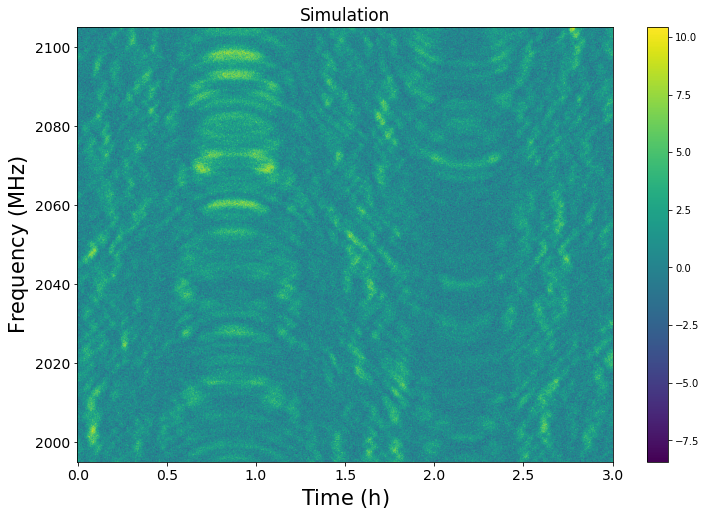

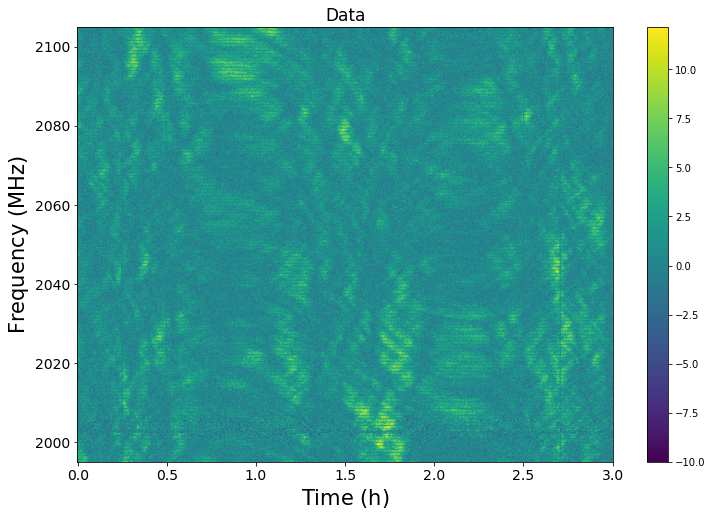

In [11]:
plt.figure(figsize=(12., 8.))

plt.imshow( ds,
           origin='lower', aspect='auto', extent=axis_extent(ts) + axis_extent(fs), 
           vmin=np.mean(ds) - 3*np.std(ds), 
           vmax = np.mean(ds) + 3*np.std(ds))

plt.ylabel(rf"Frequency ({fs.unit.to_string('latex')})", fontsize = 21)
plt.xlabel(rf"Time ({ts.unit.to_string('latex')})", fontsize = 21)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.colorbar()
plt.title('Simulation', fontsize = 17)

# plt.ylim(1005,1015)
plt.show()


plt.figure(figsize=(12., 8.))


plt.imshow( ds_data[kif:kff],
           origin='lower', aspect='auto', extent=axis_extent(ts) + axis_extent(fs_data[kif:kff]), 
           vmin= np.mean(ds_data[kif:kff]) - 3*np.std(ds_data[kif:kff]), 
           vmax = np.mean(ds_data[kif:kff]) + 3*np.std(ds_data[kif:kff]))

plt.ylabel(rf"Frequency ({fs.unit.to_string('latex')})", fontsize = 21)
plt.xlabel(rf"Time ({ts.unit.to_string('latex')})", fontsize = 21)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.colorbar()
plt.title('Data', fontsize = 17)

# plt.ylim(1005,1015)
plt.show()

In [12]:
#getting the xi, A_M, C, and delta from the inferred values in the paper
mod_xi, mod_A2, mod_C, delta = model_returner_delta(dp = d_p, 
                                                   ds= d_s , 
                                                   xi = scrn_om  , 
                                                   omp = Op,  
                                                   vism = scr_v , 
                                                   inc = inc, 
                                                   vpa = Va, 
                                                   vpd = Vd)

#function to get xi, A2 and C params to spit out A
A_model = model_Ado(mjd_t = mjd, xi = mod_xi, Amp= mod_A2, C= mod_C)

## Visualize secondary spectra

In [13]:
res_pos_data, res_dyn_data, res_kd_data, res_CS_data, res_tau_data = resampler_dimensionless( A = A_model , 
                                                                          delta = delta + np.pi, 
                                                                          nu = nu, 
                                                                          phase = phase, 
                                                                          time = ts.value, 
                                                                          dyns = ds_data[kif:kff], 
                                                                          freq = fs_data[kif:kff], 
                                                                          Nres = 1000 )

res_pos, res_dyn, res_kd, res_CS, res_tau = resampler_dimensionless( A = A_model , 
                                                                          delta = delta + np.pi, 
                                                                          nu = nu, 
                                                                          phase = phase, 
                                                                          time = ts.value, 
                                                                          dyns = ds, 
                                                                          freq = fs, 
                                                                          Nres = 1000 )


#getting the times of the turning points for a given model of a screen's A and delta
a_guess = ts[ find_zero_crossings_indices(np.gradient( ts, Ad_projection_unitless(t = ts.value, 
                                nu = nu, 
                                phase = phase, 
                                A = A_model, 
                                delta = delta + np.pi) ) ) ].value

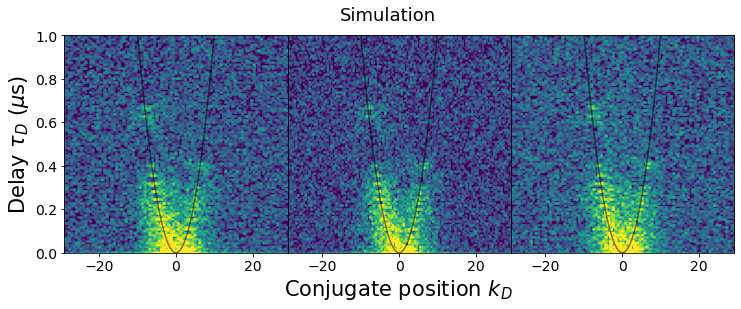

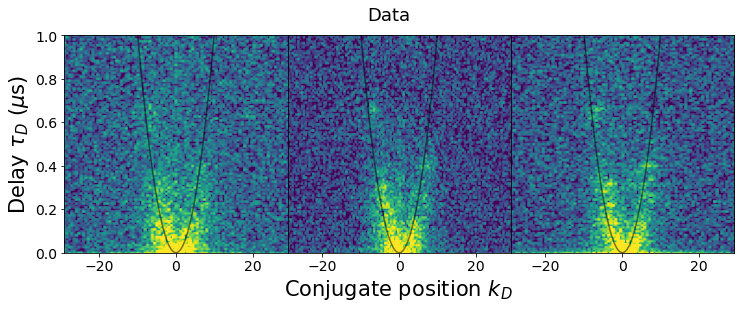

In [14]:
scalemin = 2e-6
scalemax = 1e-3
taulim = 1.
# tth_lim = 4
kdlimit = 29


#value of the resampled curvature (equivalent to Eq 29 times frequency squared)
#this is the measured value from table 1, or can also do 
# curv_constant = deff * const.c / 2 / B**2
curv_constant = 0.0427 * u.us * u.GHz**2
eta_2_use = (curv_constant / np.mean(fs)**2 )



plt.figure(figsize = (12,4))

#looping over the different regions
for i in range(len(res_dyn)):
    plt.subplot(1, len(res_dyn), i+1)
#     plt.tight_layout()
    
    if i == 0:
        ylabels = 'Delay $\\tau_D$ ($\mu$s)'
        plt.ylabel(ylabels, fontsize = 21)
    else:
        ylabels = None
        plt.subplots_adjust(wspace=0, hspace=0.35)
        plt.yticks([])
    if i == 1:
        plt.xlabel('Conjugate position $k_D$ ', fontsize = 21)
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    #normalizing to the max of the observation (just for display purposes)
    kds, taus, css = res_kd[i], res_tau.to(u.us), res_CS[i]
    SS = np.abs(css)**2 
    SS /= np.max(SS)
    
    #plotting secondary spectra
    plt.imshow(SS, 
       norm=LogNorm(vmin= scalemin,vmax=scalemax ), 
       origin='lower',
       aspect='auto',
       
       extent=ext_find( kds, taus ))
    plt.ylim(0, taulim)
    plt.xlim((- kdlimit , kdlimit))
    
    #plot curvature
    plt.plot( kds, ((kds)**2 * eta_2_use).to(u.us), c = 'k', alpha = 0.5)

    
plt.suptitle('Simulation', fontsize = 18)    
plt.show()


plt.figure(figsize = (12,4))

#looping over the different regions
for i in range(len(res_dyn)):
    plt.subplot(1, len(res_dyn), i+1)
#     plt.tight_layout()
    
    if i == 0:
        ylabels = 'Delay $\\tau_D$ ($\mu$s)'
        plt.ylabel(ylabels, fontsize = 21)
    else:
        ylabels = None
        plt.subplots_adjust(wspace=0, hspace=0.35)
        plt.yticks([])
    if i == 1:
        plt.xlabel('Conjugate position $k_D$ ', fontsize = 21)
        
    plt.tick_params(axis='both', which='major', labelsize=14)
    
    #normalizing to the max of the observation (just for display purposes)
    kds, taus, css = res_kd_data[i], res_tau_data.to(u.us), res_CS_data[i]
    SS = np.abs(css)**2 
    SS /= np.max(SS)
    
    #plotting secondary spectra
    plt.imshow(SS, 
       norm=LogNorm(vmin= scalemin,vmax=scalemax ), 
       origin='lower',
       aspect='auto',
       
       extent=ext_find( kds, taus ))
    plt.ylim(0, taulim)
    plt.xlim((- kdlimit , kdlimit))
    
    #plot curvature
    plt.plot( kds, ((kds)**2 * eta_2_use).to(u.us), c = 'k', alpha = 0.5)
    
plt.suptitle('Data', fontsize = 18)    
plt.show()